<a href="https://colab.research.google.com/github/nashapir/Vision-Projects/blob/main/VGG_on_MiniPlaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VGG on MiniPlaces (Scene Recognition)

Nathan Shapiro, nashapir

We train two neural networks, which we call MiniVGG and MiniVGG-BN. MiniVGG is a smaller, simplified version of the VGG [1] architecture, while MiniVGG-BN is identical to MiniVGG except that we added batch normalization layers after each convolution layer

Credit for problem set and portions of code to EECS 442, University of Michigan


# Setup

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101
Using the GPU!


#Scene Recognition with VGG

We break the CNN construction into the following steps

1. Contruct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [ ]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab. 
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2020-10-18 13:55:44--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip’

data_miniplaces_mod 100%[===================>] 509.86M  10.7MB/s    in 47s     

2020-10-18 13:56:31 (10.8 MB/s) - ‘data_miniplaces_modified.zip’ saved [534628730/534628730]



In [ ]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient. 
!unzip -q data_miniplaces_modified.zip

## Step 1: Build dataloaders for train, val, and test

In [ ]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    '''
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.

    '''

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    composed_transform = transforms.Compose([
      transforms.Resize(input_size),  
      transforms.ToTensor(),
      transforms.Normalize(mean, std)                                           
    ])

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}
    


    return dataloaders_dict

In [ ]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 90000
# of validation samples 10000
# of test samples 10000


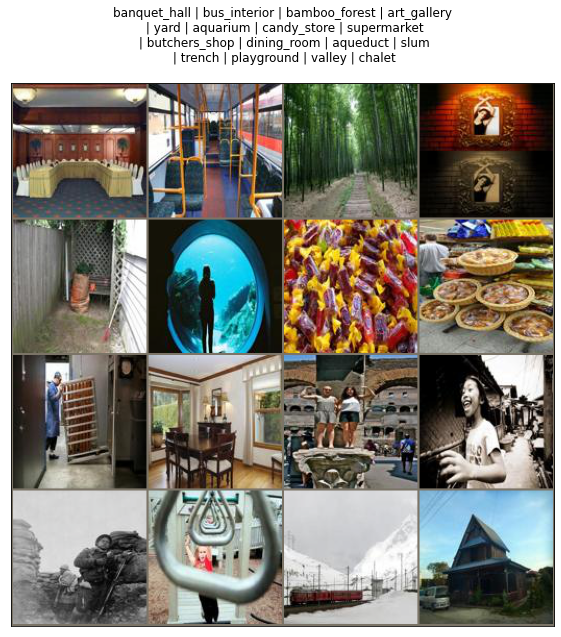

In [ ]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## Step 2. Build MiniVGG and MiniVGG-BN

See the following architectures for MiniVGG and MiniVGG-BN...

__MiniVGG architecture__

![](https://drive.google.com/uc?id=1RF3CjEsHBpRjubqwgBUxIEv54gpDjt95)

__MiniVGG-BN architecure__

![](https://drive.google.com/uc?id=1HR5N2V-5RVT1u_bVzyCvhPJZ7PSnYm6x)


In [ ]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    '''
    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [ ]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):

    '''
    Return a nn.Sequential object containing all layers to get the features using the CNN.
    (That is, before the Average pooling layer in the two pictures above). 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction layers. For use of torch.nn.Sequential, please refer to PyTorch documents.
    '''
    layers = []
    last_convo_out = 3
    for l in cfg:
      if l is 'M':
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
      else:
        layers.append(nn.Conv2d(in_channels=last_convo_out, out_channels=l, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        if batch_norm:
          layers.append(nn.BatchNorm2d(l))
        layers.append(nn.ReLU())
        last_convo_out = l

    features = nn.Sequential(*layers)

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))
         
        layers = []
        layers.append(nn.Linear(3200, 512))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=0.3))
        layers.append(nn.Linear(512, 256))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=0.3))
        layers.append(nn.Linear(256, 100))
        self.classifier = nn.Sequential(*layers)

        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=25

## Step 3: Build training/validation loops

Next, we write a function for training and validating the network. 

In [ ]:
def make_optimizer(model):
    '''
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    '''
    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    return optimizer

def get_loss():
    '''
    Returns:
        criterion: pytorch loss. 
    '''
    criterion = nn.CrossEntropyLoss()
    return criterion

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    '''
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    '''

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)  
                optimizer.zero_grad()
                # (i)
                outputs = model(inputs)
                _, preds = torch.max(outputs, dim=1)
                # (ii)
                loss = criterion(outputs, labels)
                # (iii)
                if phase is 'train':
                  loss.backward()
                  optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## Step 4. Train MiniVGG and MiniVGG-BN

In [ ]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloders and criterion function
input_size = 64 # do not change this
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [ ]:
#%xmode Verbose
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 4.5376 Acc: 0.0157


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 4.3045 Acc: 0.0309
Epoch 1/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 4.1319 Acc: 0.0569


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.8921 Acc: 0.0932
Epoch 2/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.8104 Acc: 0.1051


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.6749 Acc: 0.1300
Epoch 3/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.5845 Acc: 0.1416


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.4713 Acc: 0.1604
Epoch 4/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.3922 Acc: 0.1744


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.2370 Acc: 0.2020
Epoch 5/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.2350 Acc: 0.2011


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0834 Acc: 0.2289
Epoch 6/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.1122 Acc: 0.2266


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0259 Acc: 0.2399
Epoch 7/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9987 Acc: 0.2478


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9597 Acc: 0.2537
Epoch 8/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8939 Acc: 0.2658


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8460 Acc: 0.2764
Epoch 9/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7950 Acc: 0.2869


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8765 Acc: 0.2805
Epoch 10/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7064 Acc: 0.3052


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8129 Acc: 0.2900
Epoch 11/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6107 Acc: 0.3231


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7292 Acc: 0.3060
Epoch 12/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5249 Acc: 0.3420


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7114 Acc: 0.3105
Epoch 13/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4408 Acc: 0.3596


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7011 Acc: 0.3182
Epoch 14/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3585 Acc: 0.3763


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6919 Acc: 0.3202
Epoch 15/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2734 Acc: 0.3931


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6921 Acc: 0.3209
Epoch 16/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1926 Acc: 0.4105


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7113 Acc: 0.3205
Epoch 17/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1126 Acc: 0.4260


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7252 Acc: 0.3183
Epoch 18/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.0320 Acc: 0.4435


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7751 Acc: 0.3245
Epoch 19/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.9538 Acc: 0.4600


100%|██████████| 79/79 [00:08<00:00,  9.11it/s]

val Loss: 2.7757 Acc: 0.3158
Best val Acc: 0.324500


In [ ]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 4.2031 Acc: 0.0462


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.8170 Acc: 0.0983
Epoch 1/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.6233 Acc: 0.1258


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.4723 Acc: 0.1580
Epoch 2/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.3541 Acc: 0.1740


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.1968 Acc: 0.2022
Epoch 3/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.1875 Acc: 0.2054


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0757 Acc: 0.2247
Epoch 4/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.0573 Acc: 0.2324


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0701 Acc: 0.2335
Epoch 5/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9504 Acc: 0.2520


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8726 Acc: 0.2653
Epoch 6/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8582 Acc: 0.2714


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8926 Acc: 0.2659
Epoch 7/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7721 Acc: 0.2904


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7535 Acc: 0.2944
Epoch 8/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6994 Acc: 0.3041


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7607 Acc: 0.2968
Epoch 9/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6322 Acc: 0.3185


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6646 Acc: 0.3142
Epoch 10/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5621 Acc: 0.3314


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6598 Acc: 0.3181
Epoch 11/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4922 Acc: 0.3455


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6012 Acc: 0.3286
Epoch 12/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4390 Acc: 0.3582


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5524 Acc: 0.3442
Epoch 13/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3719 Acc: 0.3723


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6119 Acc: 0.3313
Epoch 14/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3117 Acc: 0.3846


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5815 Acc: 0.3434
Epoch 15/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2542 Acc: 0.3967


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5419 Acc: 0.3527
Epoch 16/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1947 Acc: 0.4093


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6093 Acc: 0.3435
Epoch 17/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1427 Acc: 0.4199


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7058 Acc: 0.3266
Epoch 18/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.0787 Acc: 0.4346


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6344 Acc: 0.3322
Epoch 19/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.0294 Acc: 0.4451


100%|██████████| 79/79 [00:08<00:00,  9.16it/s]

val Loss: 2.5211 Acc: 0.3561
Best val Acc: 0.356100


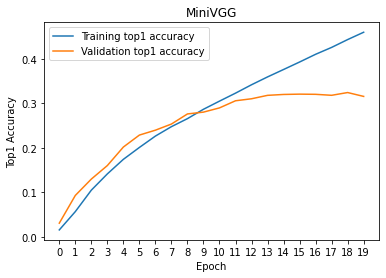

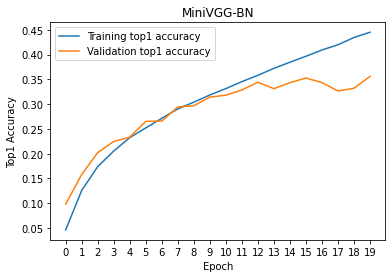

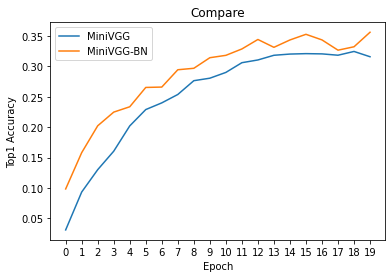

In [ ]:
# visualize the training / validation accuracies

x = np.arange(num_epochs)

# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, tr_his)
plt.plot(x, val_his)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, tr_his_BN)
plt.plot(x, val_his_BN)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, val_his)
plt.plot(x, val_his_BN)
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

### Summary of the effect of batch normalization:

The model which uses batch normalization acheives a higher validation accuracy than the model which doesn't. It also appears that the model using batch normalization creates a shakier plot of its accuracy, indicating that it is making larger leaps (both towards and away from) a more accurate model with every epoch. It's also worth noting that, despite a (relatively) consistent delta between their accuracies which is observed from the very first epoch, they seem to improve in accuracy at about the same rate. 

## Step 5. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [ ]:
def accuracy(output, target, topk=(1,)):
    '''
    Computes the accuracy over the k top predictions for the specified values of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    '''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [ ]:
##### Both networks should have Top-5 accuracy above 55% #####
vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

Top-1 accuracy 36.03%, Top-5 accuracy 66.58%
Top-1 accuracy 33.06%, Top-5 accuracy 62.18%
